This is based off an old notebook by Ben Pope. If we can recreate what he did using lightkurve alone, it will be a success!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re


import lightkurve

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings

#(the ones in comments are the ipython notebook settings)
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
lcs = lightkurve.search_lightcurvefile(8197761,cadence='long').download_all()
for j, lci in enumerate(lcs):
    lci = lci.get_lightcurve('PDCSAP_FLUX').remove_nans()
    lci = lci[lci.quality==0]
    lcs[j] = lci.normalize()

lcr = lcs[0]
for lci in lcs[1:]:
    lcr = lcr.append(lci)

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


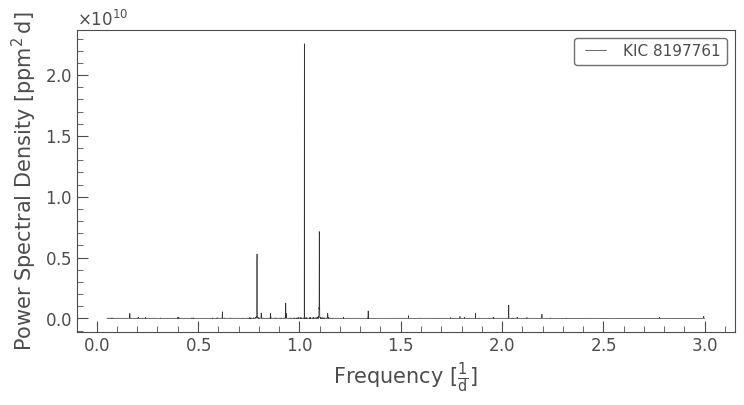

In [3]:
pg = lcr.to_periodogram(min_period = 8./24.*u.day, max_period=20.*u.day)
pg.plot()

In [4]:
y_fit = pg.get_lombscargle_model(lcr.time) #Now lightkurve functionality

(120.53833690600732, 170.53833690600732)

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


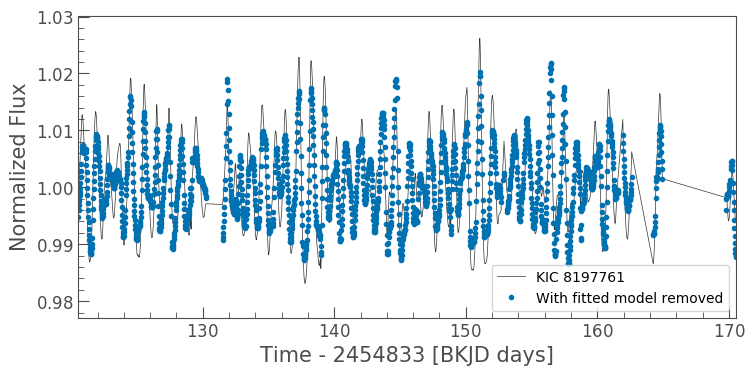

In [5]:
ax = lcr.plot()
ax.plot(lcr.time,lcr.flux-y_fit+1,'.', label='With fitted model removed')
ax.legend()
ax.set_xlim(lcr.time.min(),lcr.time.min()+50)

Lets iteratively fit sines to remove noise

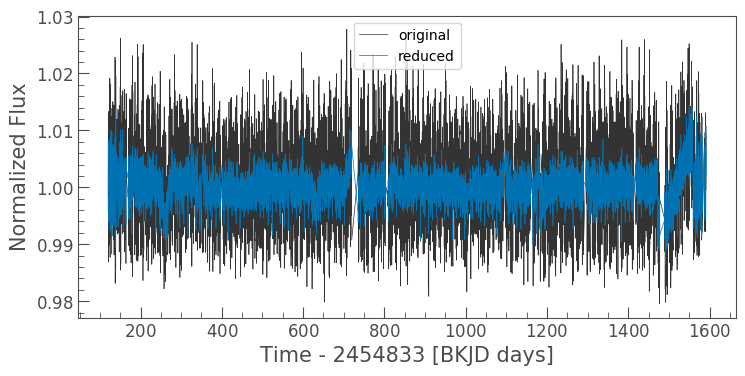

In [6]:
ff, pp = [], []
lc = lcr.copy()
for j in range(60):
    pg = lc.to_periodogram(min_period=4./24.*u.day, max_period=30.*u.day)
    ff.append(pg.frequency_at_max_power.value)
    pp.append(pg.max_power.value)
    y_fit = pg.get_lombscargle_model(lc.time)   #Now lightkurve functionality
    lc.flux = lc.flux- y_fit + 1.
    
ax = lcr.plot(label='original')
lc.plot(ax=ax, label='reduced')
ax.legend()
plt.show()

Check the flattening worked

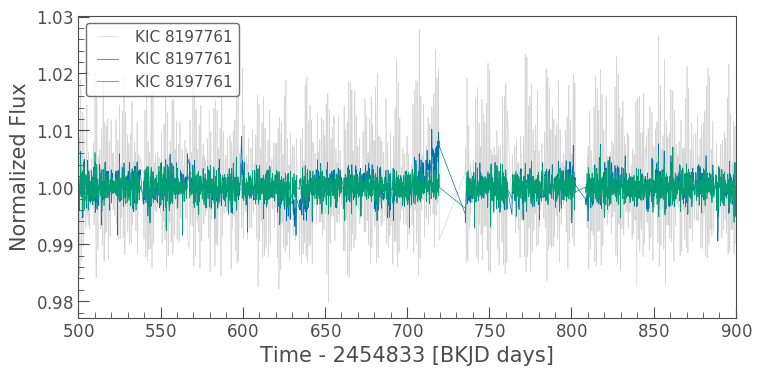

In [7]:
ax = lcr.plot(alpha=.2)
lc.plot(ax=ax)
lc.flatten().plot(ax=ax)
plt.xlim(500,900)
plt.show()

Fold the planet on the period, and bin

In [8]:
planet_period = 9.8686667
folded = lc.fold(planet_period, transit_midpoint = planet_period)
binned = folded.bin(binsize=25,method='median')

/home/oliver/.local/lib/python3.6/site-packages/lightkurve-1.0b30.dev0-py3.6.egg/lightkurve/lightcurve.py:406: LightkurveWarning: `transit_midpoint` is deprecated, please use `t0` instead.
  LightkurveWarning)


Text(0.5, 1.0, 'KIC 8197761: Period 9.869 d')

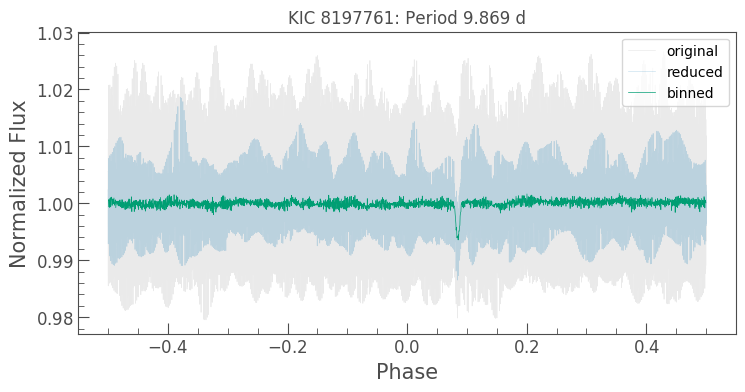

In [9]:
ax = lcr.fold(planet_period, transit_midpoint = planet_period).plot(alpha=.1, label='original')
folded.plot(alpha=.2, ax=ax, label='reduced')
binned.plot(ax=ax, label='binned')
ax.legend()
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))

# Now lets build a quick pytest

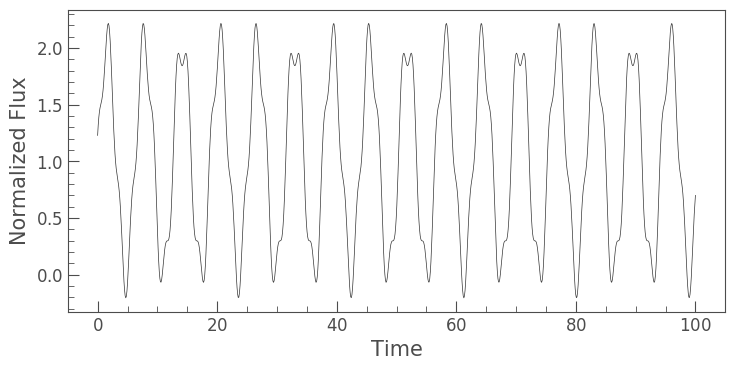

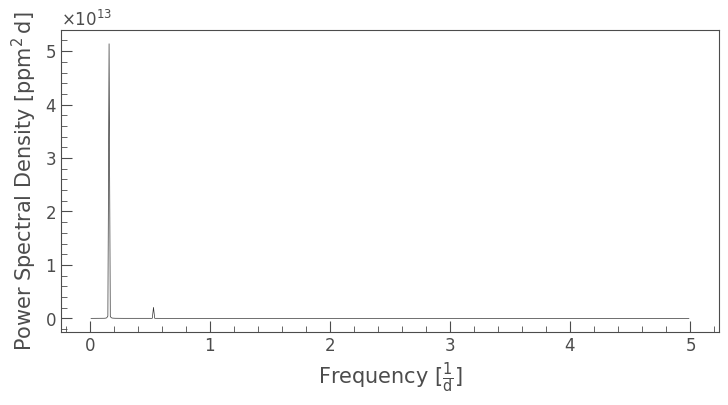

In [49]:
import lightkurve as lk
x = np.linspace(0., 100., 1000)
sinusoid1 = np.sin(x)
sinusoid2 = 0.2*np.cos(x/.3)
ytrue = sinusoid1 + sinusoid2 + 1.
# y = 0.5*np.random.randn(len(x)) + ytrue
y = ytrue
lc = lk.LightCurve(x, y)
lc.plot()
pg = lc.to_periodogram()
pg.plot()

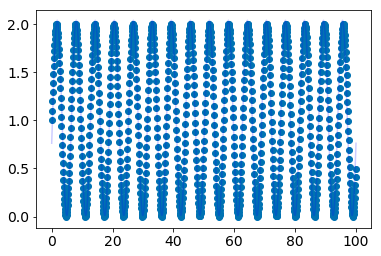

In [50]:
y_fit = pg.get_lombscargle_model(x)
plt.scatter(x, sinusoid1+1)
plt.plot(x, y_fit, c='blue', alpha=.2)

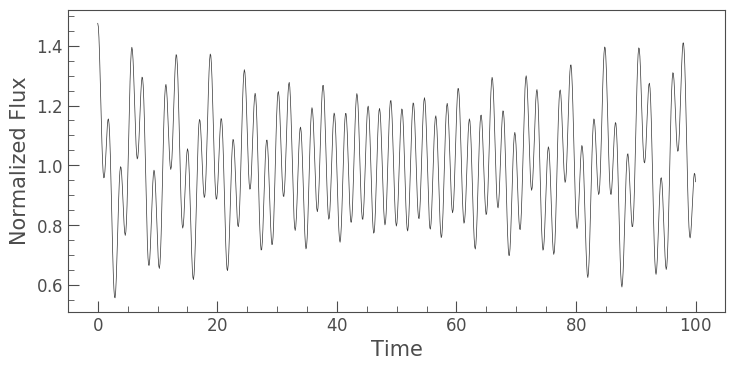

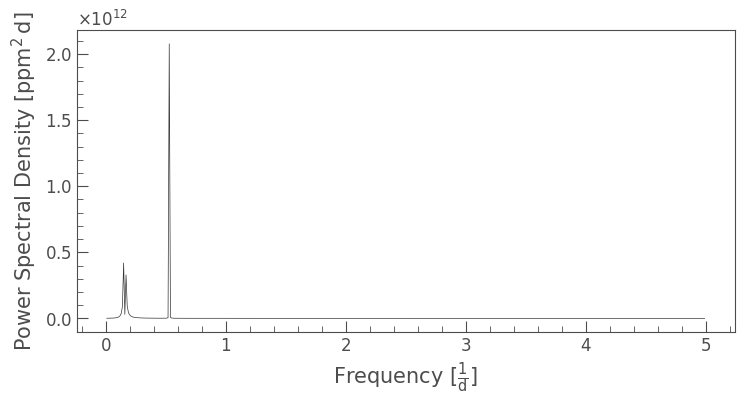

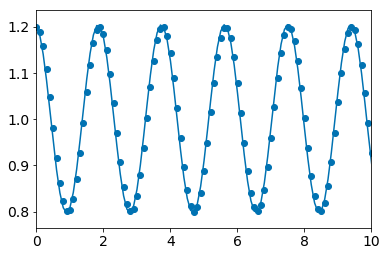

In [51]:
ynew = y - y_fit + 1
lcnew = lk.LightCurve(x, ynew)
lcnew.plot()
pgnew = lcnew.to_periodogram()
pgnew.plot()
plt.show()
y_fitnew = pgnew.get_lombscargle_model(x)
plt.scatter(x, sinusoid2+1.)
plt.plot(x, y_fitnew)
plt.xlim(0.,10.)
plt.show()